<a href="https://colab.research.google.com/github/PratikNichite/GitHubGraduation-2022/blob/main/LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# transformers: Provides tools for NLP, pandas: Handles data analysis and manipulation
!pip install transformers pandas

**ENGLISH LLM:**

In [ ]:
# Importing required libraries
import pandas as pd  # Pandas is used for handling and analyzing structured data in DataFrames
from transformers import pipeline  # Transformers library provides pre-trained NLP models for various tasks
from sklearn.feature_extraction.text import CountVectorizer  # Used for text vectorization and calculating uniqueness score

# Load a Hugging Face pipeline for Named Entity Recognition (NER)
# "grouped_entities=True" ensures that sub-word tokens are grouped into full entities (e.g., "Joh" and "n" become "John")
# The model "dbmdz/bert-large-cased-finetuned-conll03-english" is specifically fine-tuned for NER tasks
ner_pipeline = pipeline("ner", grouped_entities=True, model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Load the dataset into a Pandas DataFrame
# The CSV file path is provided as an input to read the dataset
data = pd.read_csv('/content/updated_diagnosis_disease_full_cleaned (1).csv')

# Specify all column names for pseudonymization
# target_columns will contain a list of all column names from the DataFrame
target_columns = data.columns.tolist()

# Function to calculate a uniqueness score based on the number of unique words in the text
def calculate_score(text):
    """
    Calculate the uniqueness score of the input text by counting the number of unique words.
    """
    vectorizer = CountVectorizer()  # Initialize the CountVectorizer to analyze word frequencies
    matrix = vectorizer.fit_transform([text])  # Convert the text into a frequency matrix
    return len(vectorizer.get_feature_names_out())  # Return the count of unique words (features)

# Add a new column 'Original_Score' to store the uniqueness scores before pseudonymization
data['Original_Score'] = data[target_columns].apply(
    lambda row: calculate_score(' '.join(row.dropna().astype(str))), axis=1
)  # Combine all non-null values in each row, calculate the score, and assign it to 'Original_Score'

# Define a function to pseudonymize sensitive text using the Hugging Face NER pipeline
def pseudonymize_with_transformers(text):
    """
    Replace sensitive entities in the text (e.g., Person, Organization, Location) with placeholders.
    """
    try:
        entities = ner_pipeline(text)  # Extract entities from the input text using the NER pipeline
        pseudonymized_text = text  # Initialize with the original text
        for entity in entities:  # Iterate through each detected entity
            if entity["entity_group"] in ["PER", "ORG", "LOC"]:  # Check if the entity is of a sensitive type
                # Replace the detected entity with a placeholder indicating its type
                pseudonymized_text = pseudonymized_text.replace(entity["word"], f"{entity['entity_group']}_REPLACEMENT")
        return pseudonymized_text  # Return the pseudonymized text
    except Exception as e:
        # If any error occurs during pseudonymization, print the error and return the original text
        print(f"Error during pseudonymization: {e}")
        return text

# Apply pseudonymization to all columns specified in target_columns
for column in target_columns:
    # Create new columns named 'Pseudonymized_<original_column>' for each column in target_columns
    data[f'Pseudonymized_{column}'] = data[column].apply(
        lambda x: pseudonymize_with_transformers(str(x)) if pd.notnull(x) else x  # Apply only if the value is not null
    )

# Add a new column 'Pseudonymized_Score' to store uniqueness scores after pseudonymization
data['Pseudonymized_Score'] = data[[f'Pseudonymized_{col}' for col in target_columns]].apply(
    lambda row: calculate_score(' '.join(row.dropna().astype(str))), axis=1
)  # Combine all non-null pseudonymized values in each row, calculate the score, and assign it

# Calculate the difference between original and pseudonymized uniqueness scores
data['Score_Difference'] = data['Original_Score'] - data['Pseudonymized_Score']

# Save the updated dataset with pseudonymized data to a new CSV file
output_file = '/content/updated_result_with_transformers.csv'  # Specify the output file path
data.to_csv(output_file, index=False)  # Save the DataFrame to the specified file without row indices

# Select columns for comparison, including scores and pseudonymized data
comparison_columns = ['Original_Score', 'Pseudonymized_Score', 'Score_Difference'] + [
    col for col in data.columns if 'Pseudonymized' in col or col in target_columns
]

# Extract the first 10 rows of the selected columns for display
sample_data = data[comparison_columns].head(10)

# Display a sample of the data for comparison
print("Sample Data with Original and Pseudonymized Columns:")  # Print a header for clarity
print(sample_data)  # Print the sample data to compare original and pseudonymized values
print(f"\nPseudonymized data saved to '{output_file}'")  # Confirm the output file path where data is saved

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sample Data with Original and Pseudonymized Columns:
   Original_Score Pseudonymized_Score  Score_Difference  patient_id  age  \
0              50                  50                 0        1049   62   
1              45                  45                 0        7622   61   
2              44                  44                 0        8063   59   
3              45                  45                 0        9737   21   
4              44                  44                 0        4318   53   
5              39                  39                 0        4978   32   
6              46                  46                 0        5887   69   
7              42                  42                 0        1349   23   
8              43                  43                 0        6790   59   
9              38                  38                 0         675   22   

  gender                             Diagnosis                     Remarks  \
0      M    Avascular Necrosis o

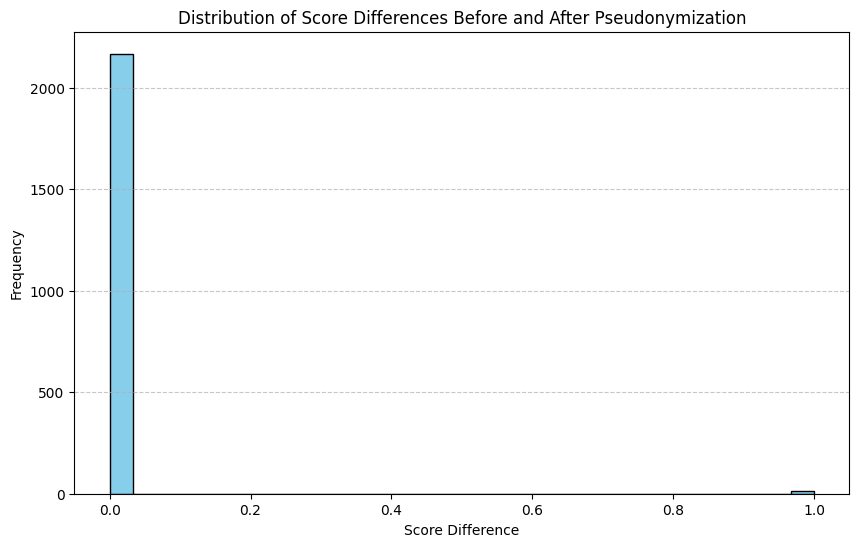

In [ ]:
 #Import the required libraries
import pandas as pd  # Pandas is used for data manipulation and analysis
import matplotlib.pyplot as plt  # Matplotlib is used for creating visualizations like plots and charts

# Load the pseudonymized dataset
# Specify the path to the CSV file generated from the pseudonymization process
output_file = '/content/updated_result_with_transformers.csv'

# Read the CSV file into a Pandas DataFrame
data = pd.read_csv(output_file)  # Load the pseudonymized data into the 'data' variable

# Plot the distribution of score differences
# This visualization will show how much the uniqueness score changed after pseudonymization

# Create a new figure with a specified size (10 inches wide and 6 inches tall)
plt.figure(figsize=(10, 6))

# Create a histogram to visualize the distribution of score differences
# Use the 'Score_Difference' column from the dataset
# Set the number of bins (intervals) to 30, and color the bars sky blue with black edges
plt.hist(data['Score_Difference'], bins=30, color='skyblue', edgecolor='black')

# Add a title to the plot
plt.title('Distribution of Score Differences Before and After Pseudonymization')

# Label the x-axis with a descriptive name
plt.xlabel('Score Difference')

# Label the y-axis with a descriptive name
plt.ylabel('Frequency')

# Add grid lines to the y-axis for better readability
# Use dashed lines ('--') with some transparency (alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()  # Render the plot to visualize the distribution



**HINDI LLM:**

In [ ]:
# Import necessary libraries
import pandas as pd  # Used for data manipulation and analysis
from transformers import pipeline  # Provides access to Hugging Face transformers for NLP tasks
from sklearn.feature_extraction.text import CountVectorizer  # Used for calculating the uniqueness score of text

# Load a Hugging Face pipeline for Named Entity Recognition (NER) specific to Hindi text
# The model "ai4bharat/indic-bert" is pre-trained for handling Indic languages
ner_pipeline = pipeline("ner", grouped_entities=True, model="ai4bharat/indic-bert")

# Load the dataset containing Hindi text
# Ensure the dataset is properly formatted and contains Hindi language content
data = pd.read_csv('/content/hindi_dataset_12_01_2024_cleaned.csv')

# Get the list of all column names in the dataset
# These columns will be targeted for pseudonymization
target_columns = data.columns.tolist()

# Function to calculate a uniqueness score for a given text
def calculate_score(text):
    vectorizer = CountVectorizer()  # Initialize a CountVectorizer to tokenize and count unique words
    matrix = vectorizer.fit_transform([text])  # Fit the text to the vectorizer and create a word frequency matrix
    return len(vectorizer.get_feature_names_out())  # Return the count of unique words in the text

# Calculate pre-pseudonymization uniqueness scores for each row in the dataset
# Combines all text from the target columns in a row, computes a uniqueness score, and stores it in a new column
data['Original_Score'] = data[target_columns].apply(
    lambda row: calculate_score(' '.join(row.dropna().astype(str))), axis=1
)

# Function to pseudonymize Hindi text using the Hugging Face NER pipeline
def pseudonymize_with_transformers(text):
    """
    Uses a Hugging Face NER pipeline to identify and replace sensitive entities in Hindi text with placeholders.
    """
    try:
        entities = ner_pipeline(text)  # Perform NER on the text to identify entities
        pseudonymized_text = text  # Start with the original text
        for entity in entities:
            # Check if the entity type is one of the targeted types (PER, ORG, LOC)
            if entity["entity_group"] in ["PER", "ORG", "LOC"]:
                # Replace the identified entity in the text with a placeholder
                pseudonymized_text = pseudonymized_text.replace(entity["word"], f"{entity['entity_group']}_REPLACEMENT")
        return pseudonymized_text  # Return the pseudonymized text
    except Exception as e:
        # Handle exceptions during the pseudonymization process
        print(f"Error during pseudonymization: {e}")
        return text  # Return the original text if an error occurs

# Apply the pseudonymization process to all target columns in the dataset
# Create new columns prefixed with 'Pseudonymized_' to store the pseudonymized text
for column in target_columns:
    data[f'Pseudonymized_{column}'] = data[column].apply(
        lambda x: pseudonymize_with_transformers(str(x)) if pd.notnull(x) else x
    )

# Calculate post-pseudonymization uniqueness scores for each row in the dataset
# Combines all pseudonymized text from the target columns in a row and computes a uniqueness score
data['Pseudonymized_Score'] = data[[f'Pseudonymized_{col}' for col in target_columns]].apply(
    lambda row: calculate_score(' '.join(row.dropna().astype(str))), axis=1
)

# Calculate the difference in uniqueness scores before and after pseudonymization
# The difference indicates the impact of pseudonymization on the uniqueness of the text
data['Score_Difference'] = data['Original_Score'] - data['Pseudonymized_Score']

# Save the pseudonymized dataset, including the new scores, to a new CSV file
output_file = '/content/updated_result_with_hindi_transformers.csv'  # Specify the output file path
data.to_csv(output_file, index=False)  # Write the DataFrame to a CSV file without including the index

# Display a sample of the data for verification
# Include columns for original and pseudonymized scores, score differences, and the pseudonymized text
comparison_columns = ['Original_Score', 'Pseudonymized_Score', 'Score_Difference'] + [
    col for col in data.columns if 'Pseudonymized' in col or col in target_columns
]
sample_data = data[comparison_columns].head(10)  # Select the first 10 rows for display
print("Sample Data with Original and Pseudonymized Columns:")  # Print a header for clarity
print(sample_data)  # Print the sample data for comparison
print(f"\nPseudonymized data saved to '{output_file}'")  # Confirm the output file path to the user



config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sample Data with Original and Pseudonymized Columns:
   Original_Score Pseudonymized_Score  Score_Difference  patient_id  age  \
0              35                  35                 0        1049   62   
1              31                  31                 0        7622   61   
2              28                  28                 0        8063   59   
3              33                  33                 0        9737   21   
4              29                  29                 0        4318   53   
5              26                  26                 0        4978   32   
6              32                  32                 0        5887   69   
7              32                  32                 0        1349   23   
8              34                  34                 0        6790   59   
9              28                  28                 0         675   22   

  gender                               Diagnosis  \
0  पुरुष    बाएं कूल्हे का अस्वास्कुलर नेक्रोसिस   
1  महि

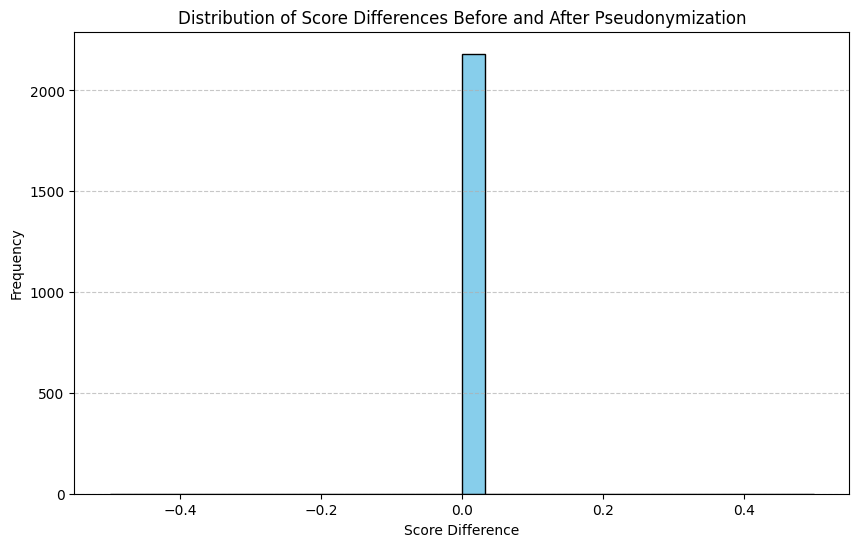

In [ ]:
# Import necessary libraries
import pandas as pd  # Used for data manipulation and analysis
import matplotlib.pyplot as plt  # Used for creating visualizations and plots

# Load the pseudonymized dataset
output_file = '/content/updated_result_with_hindi_transformers.csv'  # File path of the pseudonymized dataset
data = pd.read_csv(output_file)  # Read the CSV file into a pandas DataFrame

# Create a histogram to visualize the distribution of score differences
plt.figure(figsize=(10, 6))  # Set the figure size to make the plot more readable
plt.hist(  # Generate a histogram
    data['Score_Difference'],  # Data to plot: the 'Score_Difference' column
    bins=30,  # Number of bins to divide the data into
    color='skyblue',  # Color of the bars
    edgecolor='black'  # Color of the edges of the bars
)
plt.title('Distribution of Score Differences Before and After Pseudonymization')  # Add a title to the plot
plt.xlabel('Score Difference')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid to the y-axis for better readability

# Display the plot
plt.show()  # Render and display the plot



##  PUNJABI DATASET :

In [ ]:
# Import necessary libraries
import pandas as pd  # Used for data manipulation and analysis
from transformers import pipeline  # Hugging Face library for pre-trained models
from sklearn.feature_extraction.text import CountVectorizer  # Used for calculating uniqueness scores

# Load a Hugging Face pipeline for Named Entity Recognition (NER) for Punjabi
ner_pipeline = pipeline(
    "ner",  # Task: Named Entity Recognition
    aggregation_strategy="simple",  # Aggregates entities to avoid overlapping tokens
    model="ai4bharat/indic-bert",  # Pre-trained Indic BERT model for multiple Indian languages
    device=0  # If GPU is available, use it for faster processing
)

# Load the Punjabi dataset
data = pd.read_csv('/content/punjabi_dataset_healthcare_cleaned.csv')  # Read the dataset from a CSV file into a pandas DataFrame

# Specify all columns for pseudonymization
target_columns = data.columns.tolist()  # Get a list of all column names in the dataset

# Function to calculate uniqueness score
def calculate_score(text):
    vectorizer = CountVectorizer()  # Initialize CountVectorizer to tokenize text and count word occurrences
    matrix = vectorizer.fit_transform([text])  # Create a document-term matrix for the given text
    return len(vectorizer.get_feature_names_out())  # Return the count of unique tokens (features)

# Add pre-pseudonymization scores
data['Original_Score'] = data[target_columns].apply(
    lambda row: calculate_score(' '.join(row.dropna().astype(str))), axis=1
)  # Calculate uniqueness score for each row before pseudonymization

# Pseudonymization function for Punjabi text
def pseudonymize_with_transformers(text):
    """
    Uses a Hugging Face NER pipeline to replace sensitive entities with placeholders.
    """
    try:
        entities = ner_pipeline(text)  # Perform Named Entity Recognition on the input text
        pseudonymized_text = text  # Initialize pseudonymized text as the original text
        for entity in entities:  # Iterate over recognized entities
            if entity["entity_group"] in ["PER", "ORG", "LOC"]:  # Check if the entity type is Person, Organization, or Location
                pseudonymized_text = pseudonymized_text.replace(
                    entity["word"], f"{entity['entity_group']}_REPLACEMENT"
                )  # Replace the entity with a placeholder
        return pseudonymized_text  # Return the pseudonymized text
    except Exception as e:  # Handle any errors during pseudonymization
        print(f"Error during pseudonymization: {e}")  # Print the error message
        return text  # Return the original text in case of error

# Apply pseudonymization to all columns
for column in target_columns:
    data[f'Pseudonymized_{column}'] = data[column].apply(
        lambda x: pseudonymize_with_transformers(str(x)) if pd.notnull(x) else x
    )  # Apply the pseudonymization function to each column

# Add post-pseudonymization scores
data['Pseudonymized_Score'] = data[[f'Pseudonymized_{col}' for col in target_columns]].apply(
    lambda row: calculate_score(' '.join(row.dropna().astype(str))), axis=1
)  # Calculate uniqueness score for each row after pseudonymization

# Calculate the difference in scores
data['Score_Difference'] = data['Original_Score'] - data['Pseudonymized_Score']  # Compute the score difference before and after pseudonymization

# Save the pseudonymized dataset to a new CSV file
output_file = '/content/updated_result_with_punjabi_transformers.csv'  # Define the output file path
data.to_csv(output_file, index=False)  # Save the updated dataset to the specified CSV file

# Display a sample of the data for comparison
comparison_columns = ['Original_Score', 'Pseudonymized_Score', 'Score_Difference'] + [
    col for col in data.columns if 'Pseudonymized' in col or col in target_columns
]  # Columns to display for comparison
sample_data = data[comparison_columns].head(10)  # Select the first 10 rows for display
print("Sample Data with Original and Pseudonymized Columns:")  # Print a header for the sample data
print(sample_data)  # Display the sample data
print(f"\nPseudonymized data saved to '{output_file}'")  # Confirm the dataset has been saved successfully


Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sample Data with Original and Pseudonymized Columns:
   Original_Score Pseudonymized_Score  Score_Difference  patient_id  age  \
0              39                  39                 0        1049   62   
1              33                  33                 0        7622   61   
2              32                  32                 0        8063   59   
3              37                  37                 0        9737   21   
4              39                  39                 0        4318   53   
5              29                  29                 0        4978   32   
6              34                  34                 0        5887   69   
7              35                  35                 0        1349   23   
8              37                  37                 0        6790   59   
9              28                  28                 0         675   22   

  gender                            Diagnosis                 Remarks  \
0    ਮਰਦ        ਖੱਬੀ ਕਮਰ ਦਾ ਅਵੈਸਕੁਲਰ 

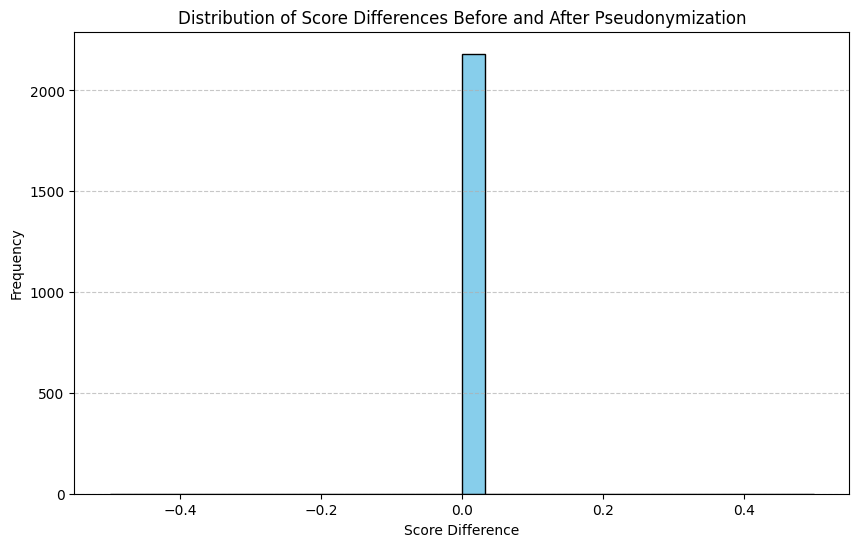

In [ ]:
# Import necessary libraries
import pandas as pd  # Used for data manipulation and analysis
import matplotlib.pyplot as plt  # Used for data visualization

# Load the pseudonymized dataset
output_file = '/content/updated_result_with_punjabi_transformers.csv'  # Path to the pseudonymized dataset
data = pd.read_csv(output_file)  # Read the dataset from the CSV file into a pandas DataFrame

# Plot the results
plt.figure(figsize=(10, 6))  # Create a new figure with a specified size (width 10 inches, height 6 inches)
plt.hist(
    data['Score_Difference'],  # Data to be plotted: differences in scores before and after pseudonymization
    bins=30,  # Divide the range of data into 30 bins (intervals)
    color='skyblue',  # Set the color of the bars to sky blue
    edgecolor='black'  # Set the color of the edges of the bars to black
)  # Create a histogram to show the frequency distribution of score differences
plt.title('Distribution of Score Differences Before and After Pseudonymization')  # Add a title to the plot
plt.xlabel('Score Difference')  # Add a label to the x-axis
plt.ylabel('Frequency')  # Add a label to the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for the y-axis with dashed lines and some transparency
plt.show()  # Display the plot

